# Load Packages

In [1]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download Dataset

In [2]:
!wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -q captcha_images_v2.zip

--2022-03-22 06:09:28--  https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip [following]
--2022-03-22 06:09:28--  https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9075967 (8.7M) [application/zip]
Saving to: ‘captcha_images_v2.zip’

captcha_images_v2.z 100%[===================>]   8.66M  --.-KB/s    in 0.09s   

2022-03-22 06:09:29 (94.4 MB/s) - ‘captcha_images_v2.zip’

# Preview Dataset

In [3]:
img_list = glob('captcha_images_v2/*.png')

len(img_list)

1040

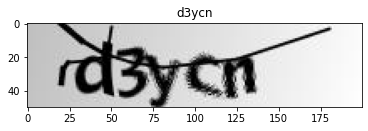

In [4]:
img = cv2.imread(img_list[0])

label = os.path.splitext(os.path.basename(img_list[0]))[0]

plt.title(label)
plt.imshow(img)

# Preprocessing

In [5]:
imgs = []
labels = []
max_length = 0

for img_path in img_list:
  imgs.append(img_path)

  label = os.path.splitext(os.path.basename(img_path))[0]
  labels.append(label)

  if len(label) > max_length:
    max_length = len(label)

print(len(imgs), len(labels), max_length)

1040 1040 5


In [6]:
''.join(labels)

'd3ycnp5g5mc353e6f857w2yp7m6n4xcgcgbxdn658n62nmbf58p5nce5ng6e2n73fmgw3n3den62cegfwce5nyw7ny7bb7b832f3ccf2w4d22m5nggggn2d3fnbfw2nf26fpw767dgc2mddgb6b4w68n34n4exnnn3m6xbm3p8gm6nnnybcxf5cm2wxcn8nbwnng888xwgnwp58pnpxfn6nf22bnwye852p2y8677g32gyb68np22nn4wx42nxyyx2d4ywn6fngn26fw3b253wp3gcfgpbdbb328x4753wb8m4fd86xen4bw44w65ebm6cwxe6fg8cgegw46megep2x7x77387n3ffn3ebnn76nxn5nxnnc86md6g45w64b3pgc2wd4egemncww7e8e5efg38bf74x344c22wecfdnfcb5p7fypdnne7ppx772enf4mpxfb68wfd387g2mcg43gng6edyxnc2en7gddmygcnex4nnfx33ygde4f8ypmdyp763pxe3fbxd2g7nmm2nf4xyyywpyefbbefbdnxn4fddnpfyd755c67455x5nxfcmem4433mgnf857634ynnn576p2gepp87nc8n8cx8e8nm3b5pc3572mwdf6cnmnn34b84n4xx5yd38emp7wp3d7bdf753f5expp574d7y33nmeng53yyn575xd2ep57fnb2g8e23mdg8b735yeyn4f6ne5dd7645mnpddmxp8yemy4bdg84xc68n87nym22d5n658xe55w5c5g5e5ep85xc3n8x5mcy7d6fcn7cgymw46ep66wp5mmg2mw4nfxmcc2x43gey5bb66f858x8n5pnwxy4nf2m8nmfb3xgm7n8w48cwdeneb7pn5g8y6b33nnpwgxx2p8nbewnwncncb8cff5e5ey5dppxgcxym23bpgfxcc8ne4ge72cdx347n56m6ymye6867dey6bdn54nc37pxne8xp24pg7wx

In [7]:
characters = set(''.join(labels))
characters

{'2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y'}

# Encode Labels

In [8]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0, mask_token=None, invert=True
)

print(labels[0])
encoded = char_to_num(tf.strings.unicode_split(labels[0], input_encoding='UTF-8'))
print(encoded)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


d3ycn
tf.Tensor([11 14 16  0  6], shape=(5,), dtype=int64)


In [9]:
tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')

'd3ycn'

# Split Dataset

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.1, random_state=2021)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

936 936
104 104


# Create Data Generator

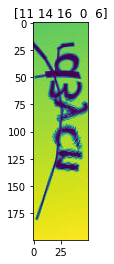

In [11]:
img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
  # 1. Read image
  img = tf.io.read_file(img_path)
  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])
  # 6. Map the characters in label to numbers
  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  # 7. Return a dict as our model is expecting two inputs
  return {'image': img, 'label': label}

preview = encode_single_sample(imgs[0], labels[0])

plt.title(str(preview['label'].numpy()))
plt.imshow(preview['image'].numpy().squeeze())

In [12]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(validation_dataset)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


# Model

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# Train

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=500,
    callbacks=[early_stopping],
)

Epoch 1/500
30/30 [==============================] - 25s 108ms/step - loss: 24.4813 - val_loss: 16.6028
Epoch 2/500
30/30 [==============================] - 2s 49ms/step - loss: 16.3453 - val_loss: 16.3331
Epoch 3/500
30/30 [==============================] - 1s 49ms/step - loss: 16.3243 - val_loss: 16.3585
Epoch 4/500
30/30 [==============================] - 1s 48ms/step - loss: 16.3251 - val_loss: 16.3654
Epoch 5/500
30/30 [==============================] - 2s 51ms/step - loss: 16.3193 - val_loss: 16.3629
Epoch 6/500
30/30 [==============================] - 2s 50ms/step - loss: 16.3156 - val_loss: 16.3632
Epoch 7/500
30/30 [==============================] - 2s 52ms/step - loss: 16.3177 - val_loss: 16.3732
Epoch 8/500
30/30 [==============================] - 2s 50ms/step - loss: 16.3129 - val_loss: 16.3863
Epoch 9/500
30/30 [==============================] - 2s 50ms/step - loss: 16.3058 - val_loss: 16.3772
Epoch 10/500
30/30 [==============================] - 2s 53ms/step - loss: 16.30

# Test Inference

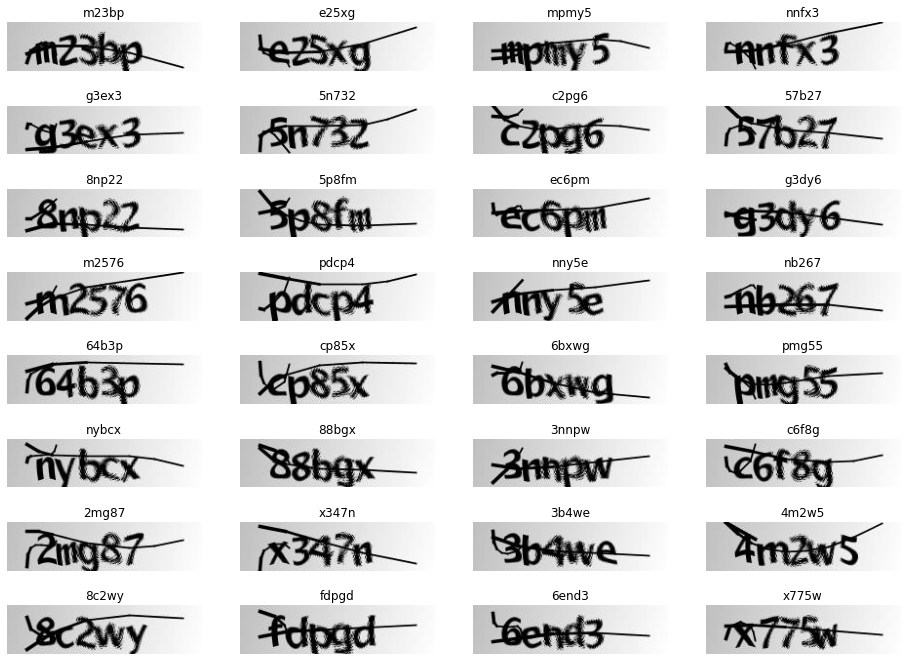

In [15]:
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(8, 4, figsize=(16, 12))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()

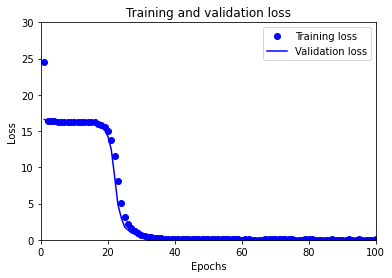

In [16]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xlim([0, 100])
plt.ylim([0, 30])


plt.show()

# Model Save

In [17]:
import joblib
joblib.dump(model, './original_model.pkl')

INFO:tensorflow:Assets written to: ram://92ad9714-628d-4a1f-9da4-a1ae768935f7/assets


INFO:tensorflow:Assets written to: ram://92ad9714-628d-4a1f-9da4-a1ae768935f7/assets


['./original_model.pkl']